In [ ]:
mkdir -p data

In [ ]:
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
!tar -xf wiki_crop.tar -C data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 패키지 로드(import)
import os
import shutil
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
# from torch.utils.data import DataLoader

In [ ]:
# !unzip '/content/drive/MyDrive/KDT/과제/6_데이터분석(팀)/나이예측모델/train.zip' -d /content/data

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/data/61/2770425_1947-06-27_2008.jpg  
  inflating: /content/data/61/2781957_1947-12-17_2008.jpg  
  inflating: /content/data/61/2806149_1941-09-13_2002.jpg  
  inflating: /content/data/61/281978_1947-01-15_2008.jpg  
  inflating: /content/data/61/2832477_1896-12-16_1957.jpg  
  inflating: /content/data/61/285438_1901-07-31_1962.jpg  
  inflating: /content/data/61/28685763_1952-03-15_2013.jpg  
  inflating: /content/data/61/2868839_1950-07-20_2011.jpg  
  inflating: /content/data/61/2886798_1954-02-09_2015.jpg  
  inflating: /content/data/61/290259_1951-03-09_2012.jpg  
  inflating: /content/data/61/29154671_1949-05-21_2010.jpg  
  inflating: /content/data/61/291795_1949-04-21_2010.jpg  
  inflating: /content/data/61/29206477_1909-08-24_1970.jpg  
  inflating: /content/data/61/2938020_1953-03-23_2014.jpg  
  inflating: /content/data/61/29463383_1949-11-27_2010.jpg  
  inflating: /content/data/61/29524021_1945-07-19_2006.jpg  
  i

In [ ]:
# import os
# import shutil
# import random

# data_folder = '/content/data'
# train_folder = '/content/train'
# validation_folder = '/content/validation'

# age_folders = [str(i) for i in range(7,94)]
# # print(age_folders)

# os.makedirs(train_folder, exist_ok=True)
# os.makedirs(validation_folder, exist_ok=True)

# for age_folder in age_folders:
#     age_folder_path = os.path.join(data_folder, age_folder)
#     image_files = os.listdir(age_folder_path)
#     random.shuffle(image_files)  # 이미지 파일을 랜덤하게 섞음

#     # 이미지 파일 중 80%는 train으로, 나머지 20%는 validation으로
#     num_train = int(0.8 * len(image_files))
#     train_images = image_files[:num_train]
#     validation_images = image_files[num_train:]

#     # train 폴더로 이미지 이동
#     for image in train_images:
#         src = os.path.join(age_folder_path, image)
#         dst = os.path.join(train_folder, image)
#         shutil.move(src, dst)

#     # validation 폴더로 이미지 이동
#     for image in validation_images:
#         src = os.path.join(age_folder_path, image)
#         dst = os.path.join(validation_folder, image)
#         shutil.move(src, dst)

# print(len(os.listdir(train_folder)))
# print(len(os.listdir(validation_folder)))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def move_folder_contents_to_parent_and_delete(folder_path):
    # folder_path: 데이터를 이동시킬 폴더의 경로

    # 해당 폴더 내 파일과 폴더 목록 가져오기
    contents = os.listdir(folder_path)

    for item in contents:
        item_path = os.path.join(folder_path, item)
        if os.path.isfile(item_path):  # 파일일 경우 상위 폴더로 이동
            shutil.move(item_path, os.path.join(folder_path, ".."))
        elif os.path.isdir(item_path):  # 폴더일 경우 하위 폴더의 파일을 상위 폴더로 이동
            sub_contents = os.listdir(item_path)
            for sub_item in sub_contents:
                sub_item_path = os.path.join(item_path, sub_item)
                shutil.move(sub_item_path, os.path.join(folder_path, ".."))

    # 폴더 삭제
    shutil.rmtree(folder_path)

# 사용 예시
folder_path_to_move = '/content/data/22//22'  # 데이터를 이동시킬 폴더의 경로
move_folder_contents_to_parent_and_delete(folder_path_to_move)


In [ ]:
import os
import random
import shutil

def split_dataset(input_path, output_path, validation_ratio=0.2, seed=None):
    # input_path: 데이터셋이 있는 폴더 경로
    # output_path: train과 validation 데이터셋을 저장할 폴더 경로
    # validation_ratio: validation 데이터셋의 비율 (0.0 ~ 1.0)
    # seed: 무작위로 데이터셋을 분할하기 위한 시드 값

    # 시드 설정 (선택사항)
    if seed is not None:
        random.seed(seed)

    # 데이터셋 폴더 내 폴더 목록과 레이블 목록 가져오기
    folders = os.listdir(input_path)

    # output_path에 train, validation 폴더 생성
    train_path = os.path.join(output_path, 'train')
    val_path = os.path.join(output_path, 'validation')
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(val_path, exist_ok=True)

    for folder in folders:
        folder_path = os.path.join(input_path, folder)
        if os.path.isdir(folder_path):
            files = os.listdir(folder_path)
            random.shuffle(files)
            num_val = int(len(files) * validation_ratio)

            # train 데이터 복사
            for file_name in files[num_val:]:
                src_path = os.path.join(folder_path, file_name)
                dst_path = os.path.join(train_path, folder)
                os.makedirs(dst_path, exist_ok=True)
                shutil.copy(src_path, dst_path)

            # validation 데이터 복사
            for file_name in files[:num_val]:
                src_path = os.path.join(folder_path, file_name)
                dst_path = os.path.join(val_path, folder)
                os.makedirs(dst_path, exist_ok=True)
                shutil.copy(src_path, dst_path)



In [ ]:
input_data_path = '/content/data'  # 데이터셋이 있는 폴더 경로
output_data_path = '/content'  # train과 validation 데이터셋을 저장할 폴더 경로

split_dataset(input_data_path, output_data_path, validation_ratio=0.2, seed=42)

In [ ]:
print(len(os.listdir(input_data_path)))
print(len(os.listdir(output_data_path)))

87
6


In [ ]:
print(os.listdir('train'))
print(os.listdir('validation'))


['18', '69', '57', '37', '31', '72', '38', '88', '43', '14', '22', '21', '36', '61', '44', '58', '23', '9', '13', '45', '63', '68', '53', '67', '77', '55', '42', '50', '91', '46', '64', '19', '75', '27', '28', '71', '59', '62', '70', '7', '82', '56', '25', '80', '16', '24', '90', '79', '60', '35', '32', '10', '49', '73', '89', '17', '48', '51', '81', '40', '87', '26', '20', '29', '11', '93', '39', '76', '30', '33', '74', '41', '12', '54', '85', '66', '65', '86', '15', '92', '34', '78', '8', '52', '47', '84', '83']
['18', '69', '57', '37', '31', '72', '38', '88', '43', '14', '22', '21', '36', '61', '44', '58', '23', '9', '13', '45', '63', '68', '53', '67', '77', '55', '42', '50', '91', '46', '64', '19', '75', '27', '28', '71', '59', '62', '70', '7', '82', '56', '25', '80', '16', '24', '90', '79', '60', '35', '32', '10', '49', '73', '89', '17', '48', '51', '81', '40', '87', '26', '20', '29', '11', '93', '39', '76', '30', '33', '74', '41', '12', '54', '85', '66', '65', '86', '15', '92', '

In [ ]:
!pip install tensorflow

In [ ]:
# import cv2
# import numpy as np
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # 이미지 크기 조정
# def resize_image(image, target_size):
#     resized_image = cv2.resize(image, target_size)
#     return resized_image

# # 정규화
# def normalize_image(image):
#     normalized_image = image / 255.0
#     return normalized_image

# # 데이터 증강
# def augment_data(images):
#     datagen = ImageDataGenerator(
#         rotation_range=20,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest'
#     )
#     augmented_images = datagen.flow(images, batch_size=len(images), shuffle=False).next()
#     return augmented_images

# # 이미지 파일 경로
# for path in train_df['파일명']:
#     image_path = path

#     # 이미지 로드
#     image = cv2.imread(image_path)

#     # 이미지 크기 조정
#     target_size = (224, 224)  # 목표 이미지 크기
#     resized_image = resize_image(image, target_size)

#     # 정규화
#     normalized_image = normalize_image(resized_image)

#     # 데이터 증강
#     images = np.array([normalized_image])  # 이미지를 배치 형태로 변환
#     augmented_images = augment_data(images)

#     # 결과 확인
#     print('Original Image Shape:', image.shape)
#     print('Resized Image Shape:', resized_image.shape)
#     print('Normalized Image Shape:', normalized_image.shape)
#     print('Augmented Images Shape:', augmented_images.shape)

#     # 이미지 표시
#     cv2_imshow(augmented_images[0])

#     # 무한 루프 방지를 위해 break 문 추가
#     break
# # 결과 확인
# # print('Original Image Shape:', image.shape)
# # print('Resized Image Shape:', resized_image.shape)
# # print('Normalized Image Shape:', normalized_image.shape)
# # print('Augmented Images Shape:', augmented_images.shape)


In [ ]:
# transforms: Compose를 사용하여 사이즈, Affine, RandomHorizontalFlip, ToTensor 역할
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.RandomAffine(0, shear=10, scale=(0.8 , 1.2)),  # 랜덤하게 변경할 것을 선택(인덱스 0번부터 10가지 선택, 크기는 범위 +-20%하여 랜덤하게 변경)
        transforms.RandomHorizontalFlip(),  # 랜덤하게 이미지 좌우 반전
        transforms.ToTensor()  # 이미지를 텐서형으로 변환
    ]),
    'validation': transforms.Compose([
        transforms.Resize([224, 224]),  # 사이즈 맞춤
        transforms.ToTensor()
    ])
}

def target_transforms(target):
  return torch.FloatTensor([target])

In [ ]:
# 데이터셋, 데이터로더(batch_size를 32) 만들기
train_folder = '/content/train'
val_folder = '/content/validation'

train_dataset = ImageFolder(train_folder, transform=data_transforms['train'])
val_dataset = ImageFolder(val_folder, transform=data_transforms['validation'])

# 데이터로더
dataloaders ={
    'train': DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True
  ),
    'validation':DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False
    )
}

print(len(train_dataset))
print(len(val_dataset))

33905
8432


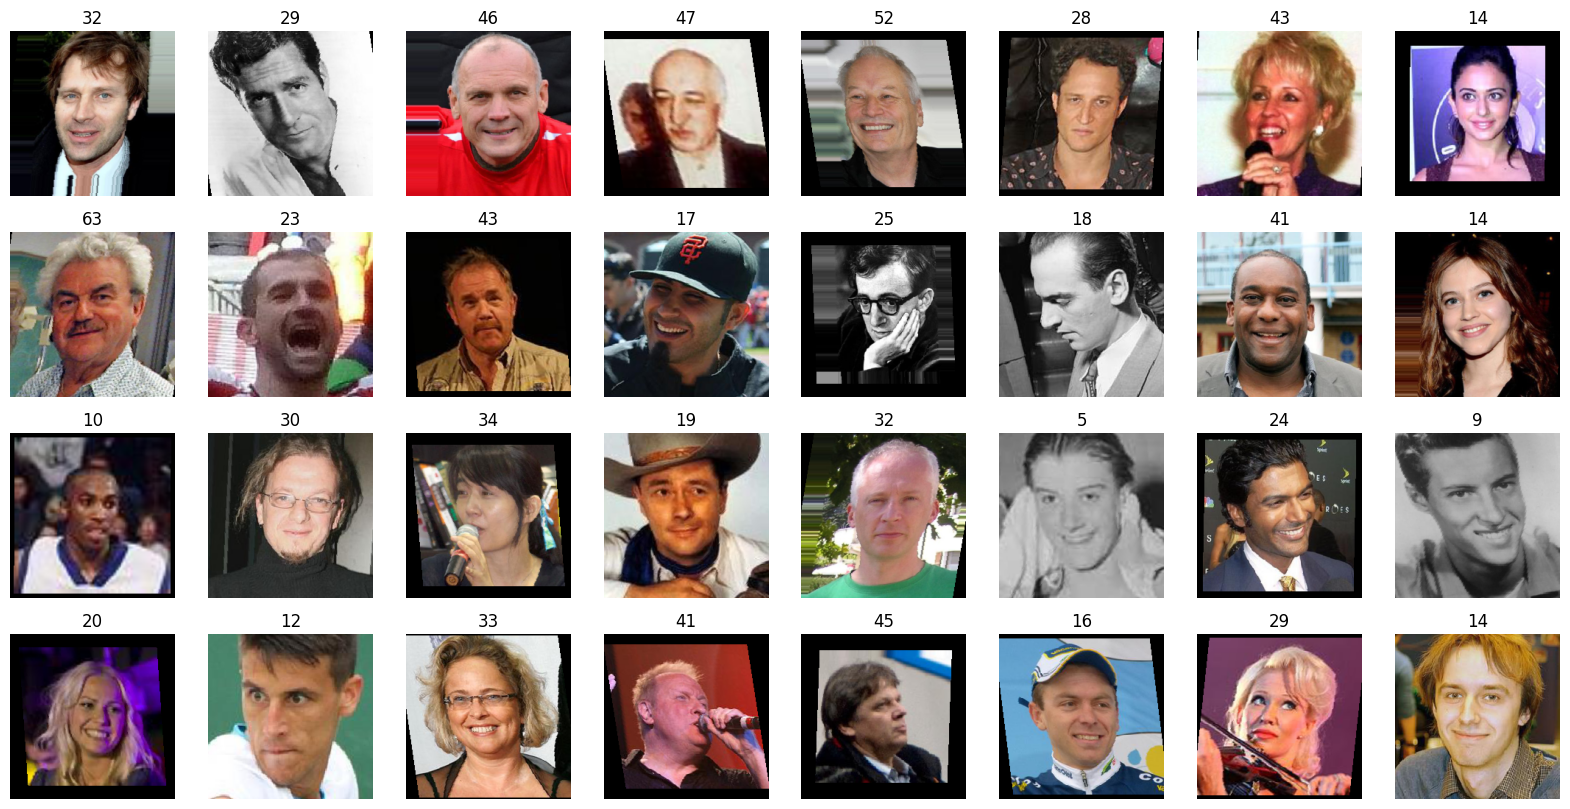

In [ ]:
# 1개의 batch만큼 이미지를 출력
imgs, labels = next(iter(dataloaders['train']))


fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
  ax.set_title(label.item())
  ax.imshow(img.permute(1,2,0))  # 텐서에 저장되어있을 때 shape(컬러, 가로, 세로) -> matplotlib에서는 (가로, 세로, 컬러채널)
  ax.axis('off')

In [ ]:
# 사전 학습된 EfficientNetB4 모델 사용(IMAGENET1K_V1)
model = models.efficientnet_b4(weights='IMAGENET1K_V1').to(device)
print(model)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:01<00:00, 45.0MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
# 파라미터는 수정하지 않고 fc 모델만 수정
for param in model.parameters():
  param.requires_grad = False  # 가져온 파라미터(W, b)를 업데이트 하지 않음

# 모델의 FC 레이어이름이 classifier
model.classifier = nn.Sequential(
    nn.Linear(1792, 42337),
    nn.ReLU(),
    nn.Linear(42337, 3000),
    nn.ReLU(),
    nn.Linear(3000, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 87)
).to(device)

# num_ftrs = model.classifier.in_features
# model._fc = nn.Linear(num_ftrs, 94)
# model._fc.to(device)

In [ ]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
# 학습
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs+1):
  for phase in ['train', 'validation']:  # train과  validation 따로 반복문을 돌아
    if phase == 'train':
      model.train()
    else:
      model.eval()   # 학습 모드에 있던 메모리를 지우고 바로 Test모드(훨씬 빠름)

    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders[phase]:  # train이라면 train에 대한 데이터로더, validataion이라면 validation에 대한 데이터로더 (따로 쓰지 않고 합쳐서 씀)
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      y_pred = model(x_batch)

      loss = nn.CrossEntropyLoss()(y_pred, y_batch.long())

      if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      sum_losses = sum_losses + loss.item()

      y_prob = nn.Softmax(1)(y_pred)
      y_pred_index = torch.argmax(y_prob, axis=1)
      acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
      sum_accs = sum_accs + acc.item()

    avg_loss = sum_losses / len(dataloaders[phase])
    avg_acc = sum_accs / len(dataloaders[phase])

    print(f'{phase:10s}: {epoch+1:4d} / {epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%')


train     :    1 / 10 Loss: 3.833154 Accuracy: 4.77%
validation:    1 / 10 Loss: 3.715531 Accuracy: 5.54%
train     :    2 / 10 Loss: 3.714592 Accuracy: 5.34%
validation:    2 / 10 Loss: 3.699723 Accuracy: 5.58%
train     :    3 / 10 Loss: 3.679306 Accuracy: 5.26%
validation:    3 / 10 Loss: 3.652925 Accuracy: 5.61%
train     :    4 / 10 Loss: 3.656661 Accuracy: 5.52%
validation:    4 / 10 Loss: 3.641218 Accuracy: 5.72%
train     :    5 / 10 Loss: 3.630344 Accuracy: 5.74%
validation:    5 / 10 Loss: 3.630424 Accuracy: 5.74%
train     :    6 / 10 Loss: 3.619059 Accuracy: 5.68%
validation:    6 / 10 Loss: 3.633394 Accuracy: 5.94%
train     :    7 / 10 Loss: 3.599751 Accuracy: 5.97%
validation:    7 / 10 Loss: 3.612715 Accuracy: 5.91%
train     :    8 / 10 Loss: 3.578955 Accuracy: 6.02%
validation:    8 / 10 Loss: 3.611001 Accuracy: 5.92%
train     :    9 / 10 Loss: 3.563989 Accuracy: 6.06%
validation:    9 / 10 Loss: 3.626177 Accuracy: 5.84%
train     :   10 / 10 Loss: 3.547673 Accuracy:

In [ ]:
# optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)  # 모델의 fc 레이어의 파라미터만 최적화
# epochs = 100
# # print(epochs)
# for epoch in range(epochs):
#     for phase in ['train', 'validation']:
#         if phase == 'train':
#             model.train()  # 모델을 학습 모드로 설정
#         else:
#             model.eval()  # 모델을 평가 모드로 설정
#         sum_losses = 0  # 손실의 합을 0으로 초기화
#         sum_accs = 0  # 정확도의 합을 0으로 초기화
#         for x_batch, y_batch in dataloaders[phase]:
#             x_batch = x_batch.to(device)  # x_batch는 미니배치
#             y_batch = y_batch.to(device)  # y_batch는 미니배치의 레이블
#             optimizer.zero_grad()  # 옵티마이저의 그래디언트를 초기화
#             with torch.set_grad_enabled(phase == 'train'):
#                 y_pred = model(x_batch)
#                 loss = nn.CrossEntropyLoss()(y_pred, y_batch)  # 손실(loss) 계산
#                 if phase == 'train':
#                     loss.backward()  # 손실(loss)을 역전파하여 파라미터를 업데이트
#                     optimizer.step()  # 옵티마이저가 가지고 있는 파라미터들을 업데이트
#             sum_losses += loss.item() * x_batch.size(0)
#             _, y_pred_labels = torch.max(y_pred, 1)
#             correct_counts = torch.sum(y_pred_labels == y_batch).item()
#             # sum_accs += correct_counts
#         avg_loss = sum_losses / len(dataloaders[phase].dataset)  # 평균 손실 계산
#         # avg_acc = sum_accs / len(dataloaders[phase].dataset) * 100  # 평균 정확도 계산
#         print(f'{phase:10s}: {epoch+1:4d} / {epochs} Loss: {avg_loss:.6f}')